In [3]:
import pandas as pd
import random
import time
from datetime import datetime, timedelta
import os # Import the os module for file system operations

# --- CONFIGURATION ---
CORE_FILE_PATH = 'CORE_2023.csv'
OUTPUT_FILE_PATH = 'conference_reviews_dataset.csv' # The file we will check for

NUM_REGULAR_USERS = 1000
NUM_INFLUENCERS = 50

REVIEWS_PER_REGULAR_USER = (5, 15)
REVIEWS_PER_INFLUENCER = (50, 100)

# --- REVIEW GENERATION ENGINE (v3) ---

# Expanded and more specific phrase library
PHRASES = {
    "positive": {
        "papers": [
            "The technical program was exceptionally strong.", "Groundbreaking research was presented throughout.",
            "The quality of accepted papers was consistently high.", "I found the sessions incredibly insightful.",
            "A fantastic lineup of papers, especially in my sub-field."
        ],
        "keynotes": [
            "The keynote speakers were world-class and truly inspiring.", "A thought-provoking and memorable keynote lineup.",
            "The opening keynote set a fantastic tone for the entire event.", "The industry keynote provided a much-needed real-world perspective."
        ],
        "networking": [
            "Exceptional networking opportunities with leading researchers.", "The social events were vibrant and well-attended.",
            "I made several valuable connections for future collaborations.", "The poster sessions were buzzing with energy and great discussions.",
            "The conference app made it easy to connect with other attendees."
        ],
        "organization": [
            "Impeccably organized from start to finish.", "The organizing committee did a phenomenal job.",
            "A beautiful and well-equipped venue.", "Registration was a breeze and the staff were very helpful.",
            "Seamless transitions between sessions and clear communication."
        ],
        "location": [
            "The host city was a wonderful choice, with plenty to see and do.", "Great location with easy access to transport and restaurants.",
            "A very scenic and enjoyable location for a conference."
        ]
    },
    "negative": {
        "papers": [
            "The technical depth of the papers was disappointing this year.", "Felt like many presentations were incremental at best.",
            "The program was too broad, lacking focus.", "Too many parallel tracks made it impossible to see everything of interest.",
            "Some presentations were rushed and poorly prepared."
        ],
        "cost": [
            "The registration fee was unjustifiably high for the value provided.", "Poor value for money, considering the additional costs.",
            "The official conference hotel was extremely overpriced.", "The cost is becoming a significant barrier for students and academics from smaller institutions."
        ],
        "organization": [
            "The organization felt chaotic and last-minute.", "Poor communication from the organizers before and during the event.",
            "The venue was too small for the number of attendees, leading to overcrowding.", "The Wi-Fi was unreliable, which is unacceptable for a tech conference.",
            "The catering was subpar and options were very limited."
        ],
        "networking": [
            "Networking felt cliquey and difficult for newcomers.", "The social events were poorly planned and sparsely attended.",
            "The poster session was disorganized and cramped.", "Very few structured opportunities to connect with senior figures in the field."
        ],
        "location": [
            "The location was inconvenient and difficult to get to.", "A boring host city with very few amenities nearby.",
            "The weather at the location was a major downside."
        ]
    },
    "neutral": {
        "observation": [
            "The conference seemed smaller than in previous years.", "There was a noticeable shift in focus towards industry applications.",
            "The hybrid format had both pros and cons.", "This year's theme was very specific.",
            "The attendance was predominantly from academia."
        ],
        "conditional": [
            "It was a good conference, although...", "While I enjoyed the keynotes, ...",
            "Overall a positive experience, but...", "The research was strong; however, ..."
        ]
    }
}

# More granular personas
PERSONAS = {
    "phd_student": {
        "pos_focus": ["networking", "papers"],
        "neg_focus": ["cost", "networking"],
        "neu_focus": ["observation"]
    },
    "early_career_researcher": {
        "pos_focus": ["papers", "networking"],
        "neg_focus": ["organization", "cost"],
        "neu_focus": ["observation"]
    },
    "senior_professor": {
        "pos_focus": ["papers", "keynotes"],
        "neg_focus": ["papers", "organization"],
        "neu_focus": ["observation"]
    },
    "industry_expert": {
        "pos_focus": ["networking", "keynotes"],
        "neg_focus": ["organization", "papers"],
        "neu_focus": ["observation"]
    },
    "sponsor_exhibitor": {
        "pos_focus": ["networking", "organization"],
        "neg_focus": ["organization", "location"],
        "neu_focus": ["observation"]
    }
}

def generate_diverse_review(rating, persona_key):
    """
    Generates a more diverse and nuanced review by decoupling review structure
    from the rating, allowing for intra-rating variety.
    """
    persona = PERSONAS[persona_key]
    review_parts = []
    
    if rating == 5:
        num_parts = random.randint(2, 4)
        aspects = random.sample(list(PHRASES["positive"].keys()), num_parts)
        if not any(p in aspects for p in persona["pos_focus"]):
            aspects[0] = random.choice(persona["pos_focus"])
        for aspect in aspects:
            review_parts.append(random.choice(PHRASES["positive"][aspect]))

    elif rating == 4:
        structure_choice = random.choice(['simple_positive', 'positive_with_gripe'])
        if structure_choice == 'simple_positive':
            num_parts = random.randint(1, 2)
            aspects = random.sample(list(PHRASES["positive"].keys()), num_parts)
            for aspect in aspects:
                review_parts.append(random.choice(PHRASES["positive"][aspect]))
        else:
            review_parts.append(random.choice(PHRASES["neutral"]["conditional"]))
            pos_aspects = random.sample(list(PHRASES["positive"].keys()), 2)
            review_parts.extend([random.choice(PHRASES["positive"][a]) for a in pos_aspects])
            neg_aspect = random.choice(persona["neg_focus"])
            review_parts.append(random.choice(PHRASES["negative"][neg_aspect]))
            random.shuffle(review_parts[1:])

    elif rating == 3:
        structure_choice = random.choice(['pro_con', 'observation'])
        if structure_choice == 'pro_con':
            pos_aspect = random.choice(persona["pos_focus"])
            neg_aspect = random.choice(persona["neg_focus"])
            review_parts.append(random.choice(PHRASES["positive"][pos_aspect]))
            review_parts.append(random.choice(PHRASES["negative"][neg_aspect]))
            random.shuffle(review_parts)
        else:
            num_parts = random.randint(1, 2)
            aspects = random.sample(list(PHRASES["neutral"]["observation"]), num_parts)
            review_parts.extend(aspects)

    elif rating == 2:
        structure_choice = random.choice(['simple_negative', 'negative_with_positive'])
        if structure_choice == 'simple_negative':
            num_parts = random.randint(1, 2)
            aspects = random.sample(list(PHRASES["negative"].keys()), num_parts)
            for aspect in aspects:
                review_parts.append(random.choice(PHRASES["negative"][aspect]))
        else:
            review_parts.append(random.choice(PHRASES["neutral"]["conditional"]))
            neg_aspects = random.sample(list(PHRASES["negative"].keys()), 2)
            review_parts.extend([random.choice(PHRASES["negative"][a]) for a in neg_aspects])
            pos_aspect = random.choice(persona["pos_focus"])
            review_parts.append(random.choice(PHRASES["positive"][pos_aspect]))
            random.shuffle(review_parts[1:])

    elif rating == 1:
        num_parts = random.randint(2, 4)
        aspects = random.sample(list(PHRASES["negative"].keys()), num_parts)
        if not any(p in aspects for p in persona["neg_focus"]):
            aspects[0] = random.choice(persona["neg_focus"])
        for aspect in aspects:
            review_parts.append(random.choice(PHRASES["negative"][aspect]))

    return ' '.join(review_parts).replace("... ", ". ").replace("..", ".")

def generate_random_timestamp():
    """Generates a random Unix timestamp from the last 3 years."""
    end_date = datetime.now()
    start_date = end_date - timedelta(days=3*365)
    random_date = start_date + (end_date - start_date) * random.random()
    return int(random_date.timestamp())

def load_conferences(file_path):
    """Loads conferences from the CORE CSV file and creates unique keys."""
    try:
        df = pd.read_csv(file_path, header=None, on_bad_lines='skip', encoding='utf-8')
        conferences = []
        for _, row in df.iterrows():
            try:
                title = str(row[1]).strip()
                acronym = str(row[2]).strip()
                if acronym and acronym != 'nan' and title:
                    key = f"{acronym} - {title}"
                    conferences.append(key)
            except (IndexError, TypeError):
                continue
        return list(set(conferences))
    except FileNotFoundError:
        print(f"Error: The file '{file_path}' was not found.")
        return None

def main():
    """Main function to generate and save the dataset."""
    
    # --- ADDED SAFETY CHECK ---
    if os.path.exists(OUTPUT_FILE_PATH):
        print(f"Dataset file '{OUTPUT_FILE_PATH}' already exists.")
        print("Generation skipped to avoid overwriting.")
        return # Exit the function early
    # --------------------------

    print("Loading conferences from CORE 2023 file...")
    conferences = load_conferences(CORE_FILE_PATH)
    if not conferences:
        print("Could not load conferences. Exiting.")
        return

    print(f"Loaded {len(conferences)} unique conferences.")

    user_ids = [f"user_{i}" for i in range(NUM_REGULAR_USERS + NUM_INFLUENCERS)]
    influencer_ids = random.sample(user_ids, NUM_INFLUENCERS)
    regular_user_ids = [uid for uid in user_ids if uid not in influencer_ids]

    user_personas = {uid: random.choice(list(PERSONAS.keys())) for uid in user_ids}

    dataset = []
    
    print("Generating reviews for influencers...")
    for user_id in influencer_ids:
        num_reviews = random.randint(*REVIEWS_PER_INFLUENCER)
        reviewed_confs = random.sample(conferences, min(num_reviews, len(conferences)))
        for conf_key in reviewed_confs:
            rating = random.choices([1, 2, 3, 4, 5], weights=[10, 15, 25, 30, 20], k=1)[0]
            review = generate_diverse_review(rating, user_personas[user_id])
            timestamp = generate_random_timestamp()
            dataset.append([user_id, conf_key, rating, review, timestamp])

    print("Generating reviews for regular users...")
    for user_id in regular_user_ids:
        num_reviews = random.randint(*REVIEWS_PER_REGULAR_USER)
        reviewed_confs = random.sample(conferences, min(num_reviews, len(conferences)))
        for conf_key in reviewed_confs:
            rating = random.choices([1, 2, 3, 4, 5], weights=[10, 15, 30, 25, 20], k=1)[0]
            review = generate_diverse_review(rating, user_personas[user_id])
            timestamp = generate_random_timestamp()
            dataset.append([user_id, conf_key, rating, review, timestamp])

    print(f"Generated a total of {len(dataset)} reviews.")

    df = pd.DataFrame(dataset, columns=['user_id', 'conference_key', 'rating', 'review', 'timestamp'])
    df.to_csv(OUTPUT_FILE_PATH, index=False)

    print(f"Dataset successfully saved to '{OUTPUT_FILE_PATH}'")

if __name__ == "__main__":
    main()

Dataset file 'conference_reviews_dataset.csv' already exists.
Generation skipped to avoid overwriting.


          DATASET ANALYSIS REPORT

[--- 1. Sample Data ---]
Here are the first 5 rows of your dataset:
| user_id   | conference_key                                                                                                                                              |   rating | review                                                                                                                                                                                                                                       |   timestamp |
|:----------|:------------------------------------------------------------------------------------------------------------------------------------------------------------|---------:|:---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|------------:|
| user_31   | FlAIRS - Fl

C:\Users\Le Loi\AppData\Local\Temp\ipykernel_9992\2144101971.py:105: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=rating_df['Rating'], y=rating_df['Count'], palette="viridis")


Saved 'rating_distribution.png'
Saved 'user_activity_distribution.png'

Analysis complete.


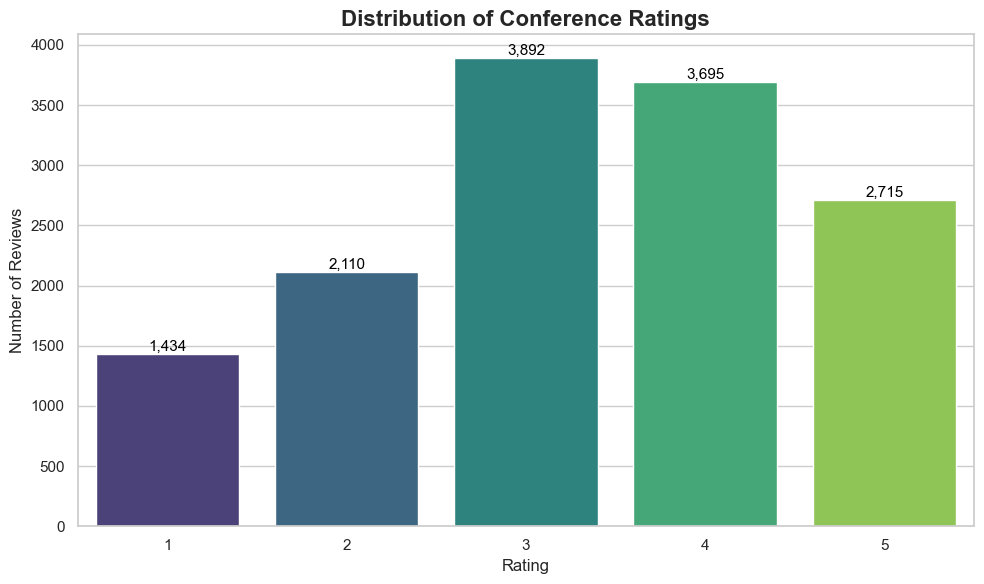

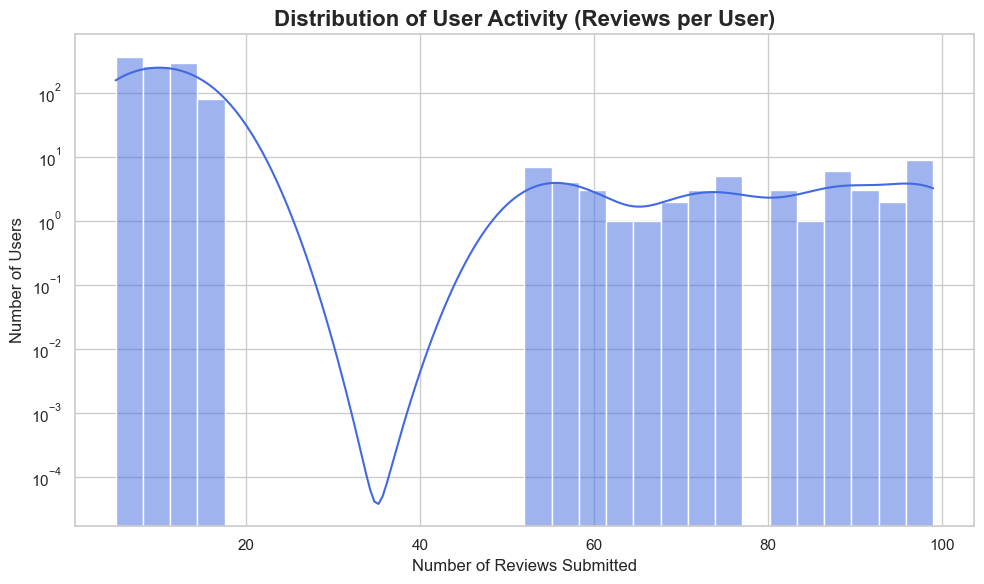

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# --- CONFIGURATION ---
DATASET_FILE_PATH = 'conference_reviews_dataset.csv'

def analyze_dataset(file_path):
    """
    Loads the dataset and performs a comprehensive statistical analysis.
    """
    # --- 1. Load Data ---
    try:
        df = pd.read_csv(file_path)
    except FileNotFoundError:
        print(f"Error: The dataset file '{file_path}' was not found.")
        print("Please run the generation script first.")
        return

    print("="*50)
    print("          DATASET ANALYSIS REPORT")
    print("="*50)

    # --- 2. Display Sample Data ---
    print("\n[--- 1. Sample Data ---]")
    print("Here are the first 5 rows of your dataset:")
    print(df.head().to_markdown(index=False))
    
    # --- 3. Overall Statistics ---
    print("\n[--- 2. Overall Statistics ---]")
    total_reviews = len(df)
    num_users = df['user_id'].nunique()
    num_conferences = df['conference_key'].nunique()
    
    stats_data = {
        "Metric": ["Total Reviews", "Unique Users", "Unique Conferences"],
        "Value": [f"{total_reviews:,}", f"{num_users:,}", f"{num_conferences:,}"]
    }
    stats_df = pd.DataFrame(stats_data)
    print(stats_df.to_markdown(index=False))

    # --- 4. User Activity Analysis ---
    print("\n[--- 3. User Activity Analysis ---]")
    user_activity = df['user_id'].value_counts()
    
    user_activity_stats = {
        "Metric": [
            "Reviews per User (Average)",
            "Reviews per User (Median)",
            "Most Active User (Reviews)",
            "Least Active User (Reviews)"
        ],
        "Value": [
            f"{user_activity.mean():.2f}",
            f"{user_activity.median():.0f}",
            f"{user_activity.max()}",
            f"{user_activity.min()}"
        ]
    }
    user_activity_df = pd.DataFrame(user_activity_stats)
    print(user_activity_df.to_markdown(index=False))
    
    # --- 5. Rating Distribution ---
    print("\n[--- 4. Rating Distribution ---]")
    rating_dist = df['rating'].value_counts().sort_index()
    rating_dist_percent = df['rating'].value_counts(normalize=True).sort_index() * 100
    
    rating_df = pd.DataFrame({
        'Rating': rating_dist.index,
        'Count': rating_dist.values,
        'Percentage (%)': rating_dist_percent.values.round(2)
    })
    print(rating_df.to_markdown(index=False))
    
    # --- 6. Review Text Analysis ---
    print("\n[--- 5. Review Text Analysis ---]")
    df['review_length'] = df['review'].str.split().str.len()
    
    review_stats = {
        "Metric": [
            "Review Length in Words (Average)",
            "Review Length in Words (Median)",
            "Longest Review (Words)",
            "Shortest Review (Words)"
        ],
        "Value": [
            f"{df['review_length'].mean():.2f}",
            f"{df['review_length'].median():.0f}",
            f"{df['review_length'].max()}",
            f"{df['review_length'].min()}"
        ]
    }
    review_stats_df = pd.DataFrame(review_stats)
    print(review_stats_df.to_markdown(index=False))
    
    # --- 7. Visualizations ---
    print("\n[--- 6. Generating Visualizations ---]")
    
    # Set plot style
    sns.set_theme(style="whitegrid")
    
    # Figure 1: Rating Distribution
    plt.figure(figsize=(10, 6))
    ax = sns.barplot(x=rating_df['Rating'], y=rating_df['Count'], palette="viridis")
    ax.set_title('Distribution of Conference Ratings', fontsize=16, fontweight='bold')
    ax.set_xlabel('Rating', fontsize=12)
    ax.set_ylabel('Number of Reviews', fontsize=12)
    # Add count labels on top of bars
    for p in ax.patches:
        ax.annotate(f'{int(p.get_height()):,}', (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha='center', va='center', fontsize=11, color='black', xytext=(0, 5),
                    textcoords='offset points')
    plt.tight_layout()
    plt.savefig('rating_distribution.png')
    print("Saved 'rating_distribution.png'")

    # Figure 2: User Activity Distribution (Histogram)
    plt.figure(figsize=(10, 6))
    ax = sns.histplot(user_activity, bins=30, kde=True, color='royalblue')
    ax.set_title('Distribution of User Activity (Reviews per User)', fontsize=16, fontweight='bold')
    ax.set_xlabel('Number of Reviews Submitted', fontsize=12)
    ax.set_ylabel('Number of Users', fontsize=12)
    ax.set_yscale('log') # Use log scale to see the long tail of influencers
    plt.tight_layout()
    plt.savefig('user_activity_distribution.png')
    print("Saved 'user_activity_distribution.png'")
    
    print("\nAnalysis complete.")
    print("="*50)


if __name__ == "__main__":
    analyze_dataset(DATASET_FILE_PATH)